In [69]:
import os
import re
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from skimage.transform import resize  # Import resize from skimage

def load_data(file_path):
    """Load chlorophyll-a data from an HDF5 file using h5py."""
    with h5py.File(file_path, 'r') as f:
        chlor_a = f['chlor_a'][:]  # Assuming the chlorophyll-a data is stored under 'chlor_a'
    return chlor_a

def extract_date_from_filename(filename):
    """Extract the date from the filename using regex."""
    match = re.search(r'(\d{8})', filename)  # Find 8 consecutive digits (YYYYMMDD format)
    if match:
        date_str = match.group(1)
        return pd.to_datetime(date_str, format='%Y%m%d')
    else:
        raise ValueError(f"Date not found in filename: {filename}")

def lat_lon_to_pixel(lat, lon):
    """Convert latitude and longitude to pixel coordinates in a 4320x8640 MODIS grid."""
    y_pixel = int((90 - lat) / 180 * 4320)
    x_pixel = int((lon + 180) / 360 * 8640)
    return y_pixel, x_pixel

def save_resized_patch(data, region_name, x_min, x_max, y_min, y_max, output_path, target_size=512):
    """Save a 32x32 patch as a resized 512x512 .png file."""
    patch = data[y_min:y_max, x_min:x_max]
    
    # Resize the 32x32 patch to 512x512
    resized_patch = resize(patch, (target_size, target_size), anti_aliasing=True)

    # Save with color bar and title
    plt.imshow(resized_patch, cmap='jet', vmin=0, vmax=20)
    plt.colorbar(label='Chlorophyll-a (mg m^-3)')
    plt.title(f'Chlorophyll-a Concentration ({region_name}) - Resized {target_size}x{target_size}')
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    plt.close()

def save_resized_patch_no_colorbar(data, x_min, x_max, y_min, y_max, output_path, target_size=512):
    """Save a 32x32 patch as a resized 512x512 .png file without color bar or title."""
    patch = data[y_min:y_max, x_min:x_max]
    
    # Resize the 32x32 patch to 512x512
    resized_patch = resize(patch, (target_size, target_size), anti_aliasing=True)

    # Save without color bar or title
    plt.imshow(resized_patch, cmap='jet', vmin=0, vmax=20)
    plt.axis('off')  # Remove axis for cleaner output
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

def process_file(file_path, output_directory):
    # Extract date from the filename
    filename = os.path.basename(file_path)
    idate = extract_date_from_filename(filename)

    # Output directory 설정
    odir = os.path.join(output_directory, f"{idate.year}/{idate.month:02d}")
    os.makedirs(odir, exist_ok=True)

    # 데이터 로드
    chlor_a = load_data(file_path)

    # 낙동강 (Nakdong River) 영역
    nakdong_lat_min, nakdong_lat_max = 33.8, 34.9
    nakdong_lon_min, nakdong_lon_max = 128.5, 129.5
    nakdong_y_min, nakdong_x_min = lat_lon_to_pixel(nakdong_lat_max, nakdong_lon_min)
    nakdong_y_max, nakdong_x_max = lat_lon_to_pixel(nakdong_lat_min, nakdong_lon_max)

    # 새만금 (Saemangeum) 영역
    saemangeum_lat_min, saemangeum_lat_max = 35.7, 36.3
    saemangeum_lon_min, saemangeum_lon_max = 125.7, 126.4
    saemangeum_y_min, saemangeum_x_min = lat_lon_to_pixel(saemangeum_lat_max, saemangeum_lon_min)
    saemangeum_y_max, saemangeum_x_max = lat_lon_to_pixel(saemangeum_lat_min, saemangeum_lon_max)

    # 32x32 패치 추출 및 512x512로 리사이즈하여 저장
    patch_size = 32

    # Center of Nakdong region
    nakdong_center_y = (nakdong_y_min + nakdong_y_max) // 2
    nakdong_center_x = (nakdong_x_min + nakdong_x_max) // 2
    nakdong_patch_region = {
        'y_min': nakdong_center_y - patch_size // 2,
        'y_max': nakdong_center_y + patch_size // 2,
        'x_min': nakdong_center_x - patch_size // 2,
        'x_max': nakdong_center_x + patch_size // 2
    }

    # Center of Saemangeum region
    saemangeum_center_y = (saemangeum_y_min + saemangeum_y_max) // 2
    saemangeum_center_x = (saemangeum_x_min + saemangeum_x_max) // 2
    saemangeum_patch_region = {
        'y_min': saemangeum_center_y - patch_size // 2,
        'y_max': saemangeum_center_y + patch_size // 2,
        'x_min': saemangeum_center_x - patch_size // 2,
        'x_max': saemangeum_center_x + patch_size // 2
    }

    # 낙동강 영역 패치 저장 (512x512 리사이즈, with colorbar)
    nakdong_output_path = f'{odir}/{idate.strftime("%Y%m%d")}_nak_bar.png'
    save_resized_patch(chlor_a, 'Nakdong River', **nakdong_patch_region, output_path=nakdong_output_path, target_size=512)

    # 새만금 영역 패치 저장 (512x512 리사이즈, with colorbar)
    saemangeum_output_path = f'{odir}/{idate.strftime("%Y%m%d")}_sae_bar.png'
    save_resized_patch(chlor_a, 'Saemangeum', **saemangeum_patch_region, output_path=saemangeum_output_path, target_size=512)

    # 낙동강 영역 패치 저장 (512x512 리사이즈, without colorbar)
    nakdong_output_path_no_bar = f'{odir}/{idate.strftime("%Y%m%d")}_nak.png'
    save_resized_patch_no_colorbar(chlor_a, **nakdong_patch_region, output_path=nakdong_output_path_no_bar, target_size=512)

    # 새만금 영역 패치 저장 (512x512 리사이즈, without colorbar)
    saemangeum_output_path_no_bar = f'{odir}/{idate.strftime("%Y%m%d")}_sae.png'
    save_resized_patch_no_colorbar(chlor_a, **saemangeum_patch_region, output_path=saemangeum_output_path_no_bar, target_size=512)

def main(directory_path, output_directory):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.endswith('.nc')]  # Only process .nc files

    # Process each file
    for file in files:
        file_path = os.path.join(directory_path, file)
        try:
            process_file(file_path, output_directory)
            print(f"Processed: {file}")
        except Exception as e:
            print(f"Failed to process {file}: {e}")

if __name__ == "__main__":
    directory_path = '/media/juneyonglee/My Book/MODIS/MODIS_aqua_8days'
    output_directory = '/media/juneyonglee/My Book/Preprocessed/MODIS'  # Specify the output directory
    main(directory_path, output_directory)


Processed: AQUA_MODIS.20170415_20170422.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20181024_20181031.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20130517_20130524.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20200625_20200702.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20200321_20200328.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20200703_20200710.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20240609_20240616.L3m.8D.CHL.chlor_a.4km.NRT.nc
Processed: AQUA_MODIS.20160406_20160413.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20141117_20141124.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20201116_20201123.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20140914_20140921.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20240101_20240108.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20210720_20210727.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20141101_20141108.L3m.8D.CHL.chlor_a.4km.nc
Processed: AQUA_MODIS.20140415_20140422.L3m.8D.CHL.chlor_a.4km.nc
Proces

/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2014/08/20140813_Saemangeum_patch.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2014/08/20140813_Nakdong_patch.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2013/08/20130821_Nakdong_patch.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2013/08/20130821_Saemangeum_patch.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2012/07/20120703_Nakdong_patch.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2012/07/20120703_Nakdong_patch_clean.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2012/07/20120703_Saemangeum_patch_clean.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2012/07/20120703_Saemangeum_patch.png
/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig/2012/07/20120703_Nakdong_Saemangeum_full_with_boxes.png


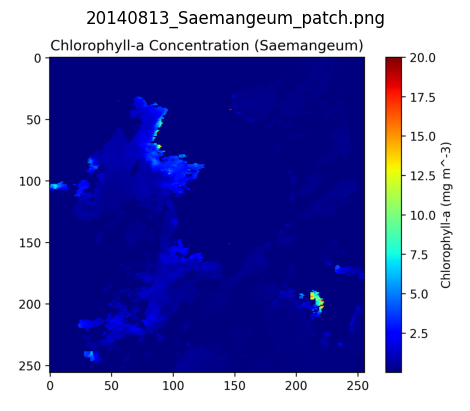

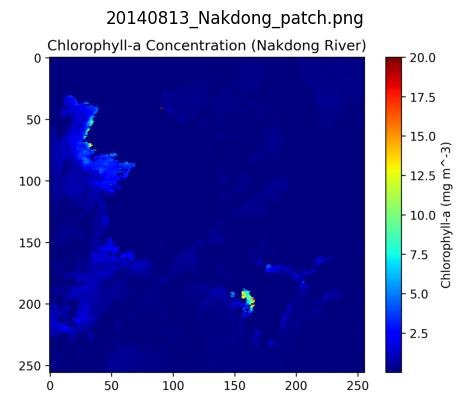

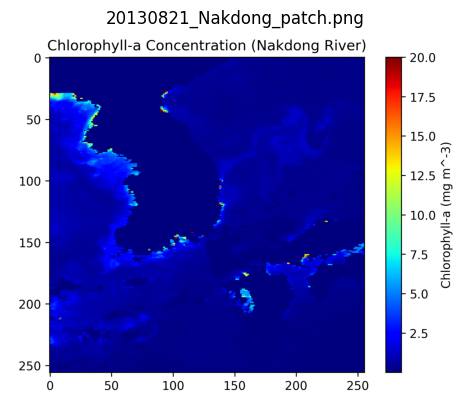

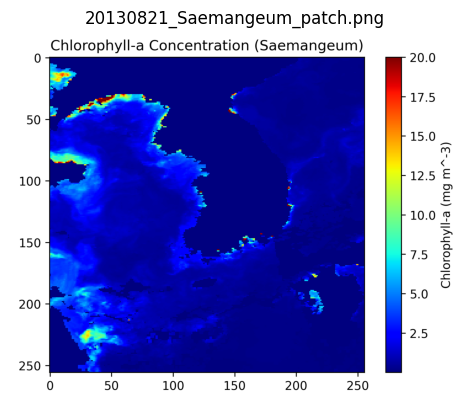

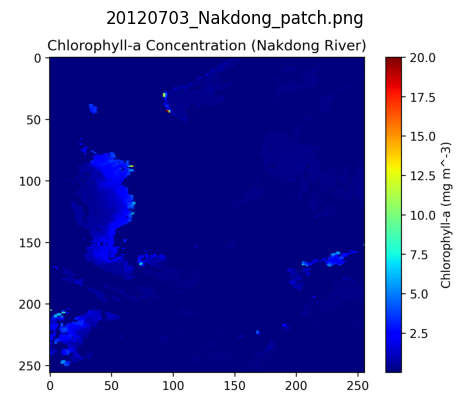

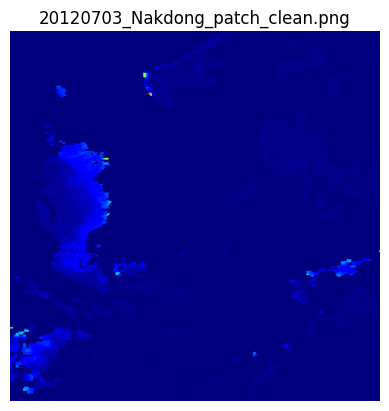

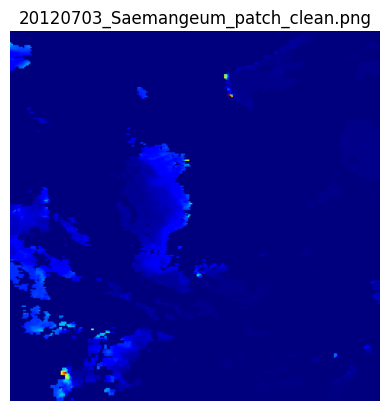

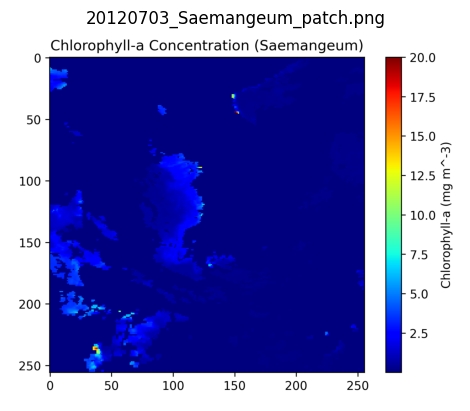

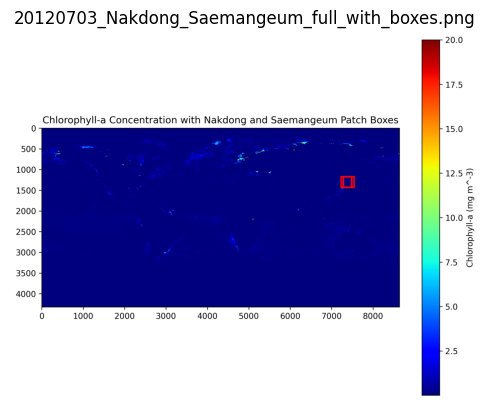

In [2]:
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# # Define the root directory where PNG files are stored
# root_directory = "/home/juneyonglee/Desktop/AY_ust/Notebook/output/fig"

# # List all PNG files from all subdirectories
# png_files = []
# for dirpath, _, filenames in os.walk(root_directory):
#     for filename in filenames:
#         if filename.endswith('.png'):
#             png_files.append(os.path.join(dirpath, filename))

# # Print all PNG file paths
# for png_file in png_files:
#     print(png_file)

# # Function to display images
# def display_images(png_files):
#     for png_file in png_files:
#         img = Image.open(png_file)
#         plt.figure()
#         plt.imshow(img)
#         plt.title(os.path.basename(png_file))
#         plt.axis('off')  # Hide axes for better viewing
#         plt.show()

# # Display the images
# display_images(png_files)


In [131]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

# Paths to directories
ust21_directory_path = '/home/juneyonglee/Desktop/AY_ust/model/performance/ust21_chl_color/ust21_chl_8day_perfect/600000/color_10/'
modis_root_directory = '/media/juneyonglee/My Book/Preprocessed/MODIS/'
save_directory = '/home/juneyonglee/MyData/backup_20240914/AY_UST/ust21_modis_difference_map'
land_sea_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.npy'  # Path to land-sea mask

# Function to extract row, column, and date from the file name
def extract_info_from_filename(filename):
    match = re.search(r'(\d{8})_.*_r(\d+)_c(\d+)', filename)
    if match:
        date = match.group(1)
        actual_row = int(match.group(2))
        actual_col = int(match.group(3))
        return date, actual_row, actual_col
    else:
        raise ValueError(f"Date or coordinates not found in filename: {filename}")

# Function to find MODIS file matching the date in the directory structure
def find_modis_file(modis_root, date, region):
    year = date[:4]
    month = date[4:6]
    
    modis_dir = os.path.join(modis_root, year, month)
    
    if os.path.exists(modis_dir):
        for file in os.listdir(modis_dir):
            if region in file and date in file and '_bar' not in file:
                return os.path.join(modis_dir, file)
    
    return None

# Function to map UST21 coordinates to MODIS coordinates
def map_ust21_to_modis(actual_row, actual_col, ust21_size, modis_size, region):
    x_nak, y_nak = (3751, 4757)
    x_sae, y_sae = (3505, 3920)

    if region == 'nak':
        modis_row = actual_row - x_nak
        modis_col = actual_col - y_nak + 256
    elif region == 'sae':
        modis_row = actual_row - x_sae + 256
        modis_col = actual_col - y_sae + 512
    else:
        raise ValueError(f"Invalid region specified: {region}. Must be 'nak' or 'sae'.")
    
    return modis_row, modis_col

# Function to find corresponding MODIS 256x256 patch from a MODIS image
def find_modis_patch_from_ust21(actual_row, actual_col, modis_patch, region, ust21_patch_size=512, modis_patch_size=256):
    modis_row, modis_col = map_ust21_to_modis(actual_row, actual_col, (ust21_patch_size, ust21_patch_size), modis_patch.shape, region)
    
    modis_patch_resized = resize(modis_patch, (modis_patch_size, modis_patch_size), anti_aliasing=True)

    return modis_patch_resized

# Function to compute difference map
def compute_difference_map(ust21_patch, modis_patch):
    if ust21_patch.shape != modis_patch.shape:
        raise ValueError("UST21 patch and MODIS patch must have the same shape.")
    
    diff_map = ust21_patch - modis_patch
    return diff_map

# Function to compute RMSE for a list of difference maps
def compute_rmse(difference_maps):
    rmse = np.sqrt(np.mean(np.square(difference_maps)))
    return rmse

# Function to visualize and save the difference map with land-sea mask
def visualize_difference_map(diff_map, region_name, row, col, land_sea_mask_path, save_path):
    diff_map_normalized = (diff_map - np.min(diff_map)) / (np.max(diff_map) - np.min(diff_map))

    # Load the land-sea mask
    land_mask_full = np.load(land_sea_mask_path)
    land_mask_cropped = land_mask_full[row:row + 256, col:col + 256]

    # Set land areas (mask == 1) to black in the difference map
    land_mask = (land_mask_cropped == 1)
    diff_map_normalized[land_mask] = np.nan  # Exclude land from colormap

    plt.figure(figsize=(6, 6))
    plt.imshow(diff_map_normalized, cmap='RdBu_r', vmin=-20, vmax=20)
    plt.colorbar(label='Chlorophyll-a Difference (mg m^-3)')
    plt.title(f'Difference Map: {region_name}')
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
def compute_rmse(difference_maps):
    rmse = np.sqrt(np.mean(np.square(difference_maps)))
    return rmse

# Function to compute and visualize RMSE scatter plot with all RMSE points and overall average
def visualize_rmse_scatter_by_year(rmse_by_year, region_name, save_path):
    years = []
    rmse_values = []
    
    for year, rmse_list in rmse_by_year.items():
        years.extend([year] * len(rmse_list))  # Add the year for each RMSE point
        rmse_values.extend(rmse_list)  # Add all RMSE values for that year
    
    # Compute the overall average RMSE
    overall_average_rmse = np.mean(rmse_values)

    # Create a scatter plot with all RMSE points
    plt.figure(figsize=(8, 6))
    plt.scatter(years, rmse_values, color='blue', s=100, edgecolor='black')
    
    # Annotate each point with RMSE values
    for i, (year, rmse_value) in enumerate(zip(years, rmse_values)):
        plt.text(years[i], rmse_values[i], f'{rmse_value:.2f}', fontsize=8, ha='center', va='bottom')

    plt.xlabel('Year')
    plt.ylabel('RMSE (mg m^-3)')
    plt.title(f'RMSE Over Years: {region_name}')
    plt.grid(True)

    # Display the overall average RMSE in the bottom-right corner of the graph
    plt.text(0.8, 0.05, f'Overall Average RMSE: {overall_average_rmse:.2f}', fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes)

    # Save the scatter plot
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()


# Function to process files and calculate difference map, RMSE, and Mean Bias per year
def process_files(directory, modis_root, save_dir, land_sea_mask_path):
    os.makedirs(save_dir, exist_ok=True)
    
    files = os.listdir(directory)
    rmse_by_year_nakdong = {}
    rmse_by_year_saemangeum = {}
    difference_maps_nakdong = []
    difference_maps_saemangeum = []

    for file in files:
        if file.endswith('.png') and '_bar' not in file:
            ust21_date, actual_row, actual_col = extract_info_from_filename(file)
            year = int(ust21_date[:4])  # Extract the year as an integer

            modis_nakdong = find_modis_file(modis_root, ust21_date, 'nak')
            modis_saemangeum = find_modis_file(modis_root, ust21_date, 'sae')

            if modis_nakdong and 'nak' in file:
                region = 'nak'
                modis_patch = imread(modis_nakdong)
                ust21_patch = imread(os.path.join(directory, file))
                ust21_patch = resize(ust21_patch, (256, 256))
                
                modis_patch_256 = find_modis_patch_from_ust21(actual_row, actual_col, modis_patch, region=region)
                diff_map = compute_difference_map(ust21_patch, modis_patch_256)
                difference_maps_nakdong.append(diff_map)

                # Compute RMSE for this patch and store by year
                patch_rmse = compute_rmse(diff_map)
                if year not in rmse_by_year_nakdong:
                    rmse_by_year_nakdong[year] = []
                rmse_by_year_nakdong[year].append(patch_rmse)
                
                save_path = os.path.join(save_dir, f'difference_map_nakdong_{ust21_date}_r{actual_row}_c{actual_col}.png')
                visualize_difference_map(diff_map, region, actual_row, actual_col, land_sea_mask_path, save_path)

            if modis_saemangeum and 'sae' in file:
                region = 'sae'
                modis_patch = imread(modis_saemangeum)
                ust21_patch = imread(os.path.join(directory, file))
                ust21_patch = resize(ust21_patch, (256, 256))
                
                modis_patch_256 = find_modis_patch_from_ust21(actual_row, actual_col, modis_patch, region=region)
                diff_map = compute_difference_map(ust21_patch, modis_patch_256)
                difference_maps_saemangeum.append(diff_map)

                # Compute RMSE for this patch and store by year
                patch_rmse = compute_rmse(diff_map)
                if year not in rmse_by_year_saemangeum:
                    rmse_by_year_saemangeum[year] = []
                rmse_by_year_saemangeum[year].append(patch_rmse)
                
                save_path = os.path.join(save_dir, f'difference_map_saemangeum_{ust21_date}_r{actual_row}_c{actual_col}.png')
                visualize_difference_map(diff_map, region, actual_row, actual_col, land_sea_mask_path, save_path)

    # Compute and visualize RMSE scatter plot per year for Nakdong
    if rmse_by_year_nakdong:
        visualize_rmse_scatter_by_year(rmse_by_year_nakdong, 'Nakdong', os.path.join(save_dir, 'rmse_scatter_nakdong.png'))

    # Compute and visualize RMSE scatter plot per year for Saemangeum
    if rmse_by_year_saemangeum:
        visualize_rmse_scatter_by_year(rmse_by_year_saemangeum, 'Saemangeum', os.path.join(save_dir, 'rmse_scatter_saemangeum.png'))

# Call the process function
process_files(ust21_directory_path, modis_root_directory, save_directory, land_sea_mask_path)
